In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objs as go
plt.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, RocCurveDisplay

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv


In [2]:
fraud = pd.read_csv('../input/paysim1/PS_20174392719_1491204439457_log.csv')

In [3]:
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
fraud.shape

(6362620, 11)

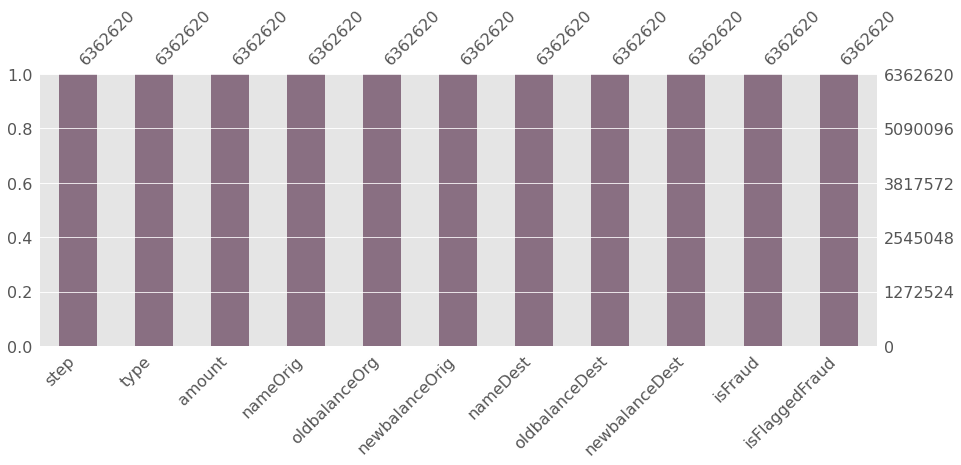

In [6]:
plt.figure(figsize = (15, 8))
msno.bar(fraud, figsize = (15,5), sort = 'ascending', color = "#896F82")
plt.show()

In [7]:
print('Number of duplicates are : ', fraud.duplicated().sum())

Number of duplicates are :  0


In [8]:
fraud.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [9]:
fraud = fraud.rename(columns = {'nameOrig' : 'origin', 'oldbalanceOrg' : 'sender_old_balance', 'newbalanceOrig': 'sender_new_balance', 'nameDest' : 'destination', 'oldbalanceDest' : 'receiver_old_balance', 'newbalanceDest': 'receiver_new_balance', 'isFraud' : 'isfraud'})

In [10]:
fraud = fraud.drop(columns = ['step', 'isFlaggedFraud'], axis = 'columns')

In [11]:
cols = fraud.columns.tolist()
new_position = 3

cols.insert(new_position, cols.pop(cols.index('destination')))
fraud = fraud[cols]

In [12]:
fraud.head()

,type,amount,origin,destination,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,isfraud
0,PAYMENT,9839.64,C1231006815,M1979787155,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,1864.28,C1666544295,M2044282225,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,181.00,C1305486145,C553264065,181.0,0.00,0.0,0.0,1
3,CASH_OUT,181.00,C840083671,C38997010,181.0,0.00,21182.0,0.0,1
4,PAYMENT,11668.14,C2048537720,M1230701703,41554.0,29885.86,0.0,0.0,0


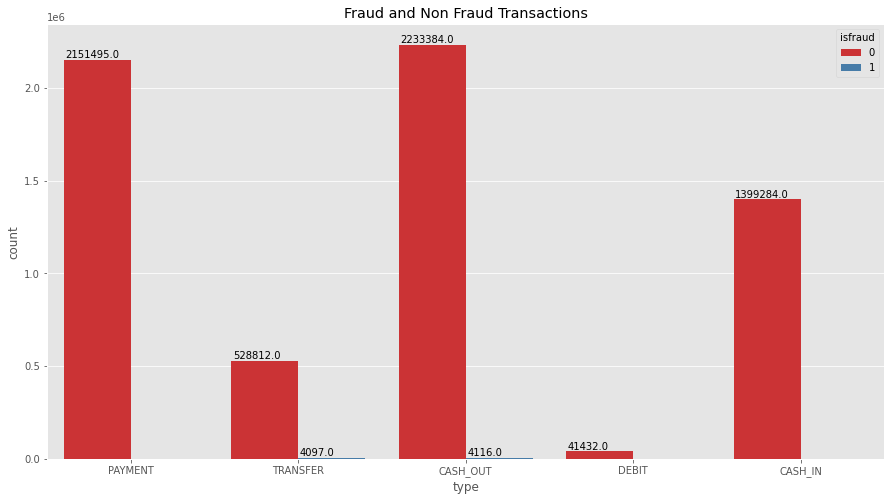

In [13]:
plt.figure(figsize = (15, 8))
ax=sns.countplot(data = fraud, x = "type", hue="isfraud", palette = 'Set1')
plt.title('Fraud and Non Fraud Transactions')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000))

In [14]:
transfer_fraud = fraud[((fraud['type']=='TRANSFER') & fraud['isfraud']==1)]
transfer_fraud['origin'].value_counts()

C1305486145    1
C202278158     1
C12585107      1
C946427395     1
C1069177491    1
              ..
C2090764492    1
C1794935564    1
C318078280     1
C939293281     1
C1685995037    1
Name: origin, Length: 4097, dtype: int64

In [15]:
cash_out_fraud = fraud[(fraud['type'] == 'CASH_OUT') & (fraud['isfraud'] == 1)]
cash_out_fraud['destination'].value_counts()

C200064275     2
C1399829166    2
C1650668671    2
C2129197098    2
C1013511446    2
              ..
C1566713324    1
C1955464150    1
C1104137869    1
C377165949     1
C873221189     1
Name: destination, Length: 4091, dtype: int64

In [ ]:
fraud_trans = fraud[fraud['isfraud'] == 1]
valid_trans = fraud[fraud['isfraud'] == 0]

trans_transfer = fraud[fraud['type'] == 'TRANSER']
trans_cashout = fraud[fraud['type'] == 'CASH_OUT']

print('Has the receiving accoung used for cashing out?')
trans_transfer.destination.isin(trans_cashout.origin).any()

In [17]:
data = fraud.copy()
data['type2'] = np.nan
data.loc[fraud.origin.str.contains('C') & fraud.destination.str.contains('C'), 'type2'] = 'CC'
data.loc[fraud.origin.str.contains('C') & fraud.destination.str.contains('M'), 'type2'] = 'CM'
data.loc[fraud.origin.str.contains('M') & fraud.destination.str.contains('C'), 'type2'] = 'MC'
data.loc[fraud.origin.str.contains('M') & fraud.destination.str.contains('C'), 'type2'] = 'MM'

In [18]:
cols = data.columns.tolist()
new_position = 1

cols.insert(new_position, cols.pop(cols.index('type2')))
data = data[cols]

In [19]:
data.drop(columns = ['origin','destination'], axis = 'columns', inplace = True)

In [20]:
data.head()

,type,type2,amount,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,isfraud
0,PAYMENT,CM,9839.64,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,CM,1864.28,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,CC,181.00,181.0,0.00,0.0,0.0,1
3,CASH_OUT,CC,181.00,181.0,0.00,21182.0,0.0,1
4,PAYMENT,CM,11668.14,41554.0,29885.86,0.0,0.0,0


In [21]:
fraud_trans = data[data['isfraud'] == 1]
valid_trans = data[data['isfraud'] == 0]

print('Number of fraud transactions according to type are below:\n', fraud_trans.type2.value_counts(), '\n')
print('Number of valid transactions according to type are below:\n', valid_trans.type2.value_counts())

Number of fraud transactions according to type are below:
 CC    8213
Name: type2, dtype: int64 

Number of valid transactions according to type are below:
 CC    4202912
CM    2151495
Name: type2, dtype: int64


In [22]:
fr = fraud_trans.type2.value_counts()
va = valid_trans.type2.value_counts()

Text(0.5, 1.0, 'Valid')

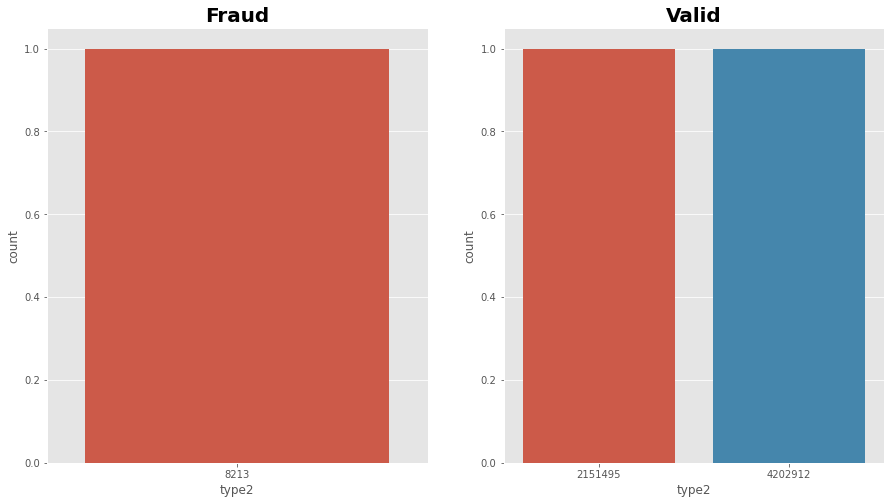

In [23]:
plt.figure(figsize=(15, 8))
plt.subplot(1,2,1)
sns.countplot(x = fr)
plt.title('Fraud',fontweight="bold", size=20)
plt.subplot(1,2,2)
sns.countplot(x = va)
plt.title('Valid',fontweight="bold", size=20)

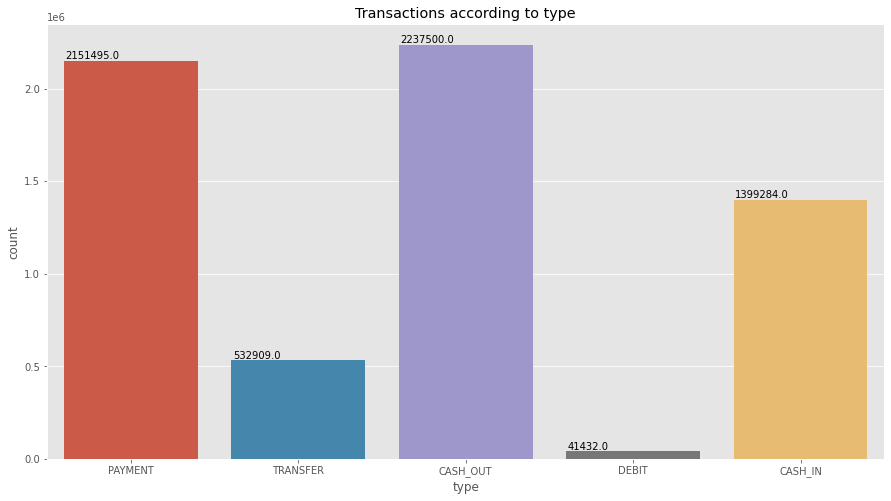

In [24]:
plt.figure(figsize = (15, 8))
ax=sns.countplot(data = data, x = "type")
plt.title('Transactions according to type')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000))

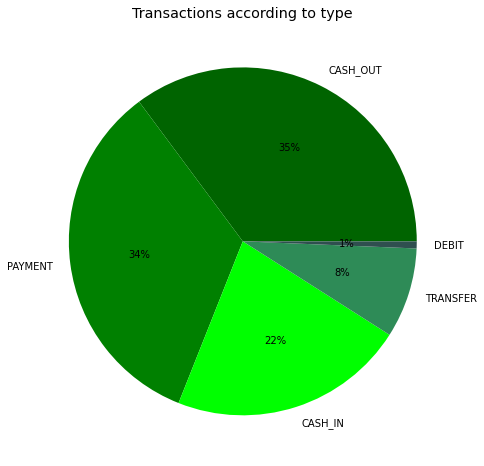

In [25]:
plt.figure(figsize=(15,8))
colors = ['#006400','#008000','#00FF00','#2E8B57','#2F4F4F']
plt.pie(data.type.value_counts().values,labels=data.type.value_counts().index, colors = colors, autopct='%.0f%%')
plt.title("Transactions according to type")
plt.show()

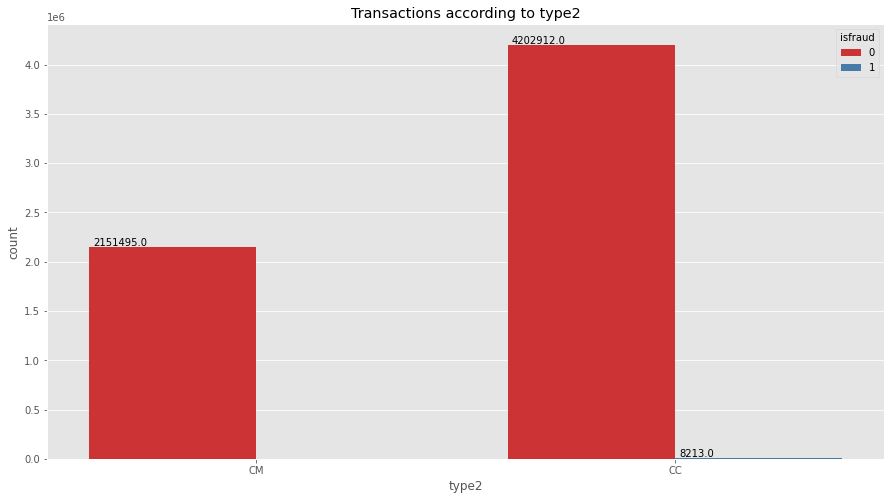

In [26]:
plt.figure(figsize = (15, 8))
ax=sns.countplot(data = data, x = "type2", hue="isfraud", palette = 'Set1')
plt.title('Transactions according to type2')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000))

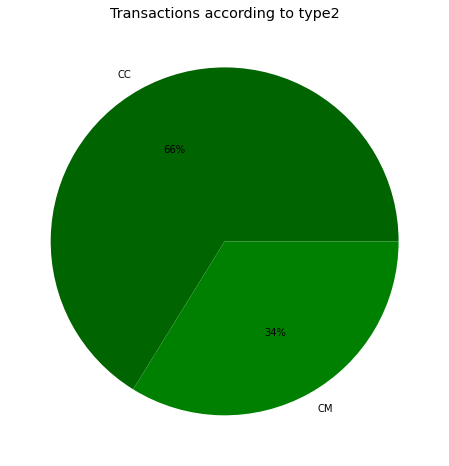

In [27]:
plt.figure(figsize=(15,8))
colors = ['#006400','#008000']
plt.pie(data.type2.value_counts().values,labels=data.type2.value_counts().index, colors = colors,  autopct='%.0f%%')
plt.title("Transactions according to type2")
plt.show()

In [28]:
data = pd.get_dummies(data, prefix = ['type', 'type2'], drop_first = True)

In [29]:
X = data.drop('isfraud', 1)
y = data.isfraud

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = data.isfraud)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [30]:
rfc=RandomForestClassifier(n_estimators = 15, n_jobs = -1, random_state = 42)
lgbm = LGBMClassifier(boosting_type = 'gbdt',objective = 'binary', random_state = 8888)
xgbr = xgb.XGBClassifier(max_depth = 3, n_jobs = -1, random_state = 42, learning_rate = 0.1)
logreg = LogisticRegression(solver = 'liblinear', random_state = 42)

rfc.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
xgbr.fit(X_train, y_train)
logreg.fit(X_train, y_train)

classifiers = []
classifiers.append(rfc)
classifiers.append(lgbm)
classifiers.append(xgbr)
classifiers.append(logreg)

In [31]:
accuracy_list = []
auc_list = []

for classifier in classifiers:
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:,1]
    accuracy_list.append(accuracy_score(y_test, y_pred))
    auc_list.append(roc_auc_score(y_test, y_pred_proba))

accuracy_dict = {}
auc_dict = {}
for i in range(4):
    key=['Random Forest', 'Light GBM', 'XGBoost','LR'][i]
    accuracy_dict[key] = accuracy_list[i]
    auc_dict[key] = auc_list[i]
    
accuracy_dict_sorted = dict(sorted(accuracy_dict.items(), key = lambda item: item[1]))
auc_dict_sorted = dict(sorted(auc_dict.items(), key = lambda item: item[1]))

In [32]:
def px_bar(x,y,text,title,color,color_discrete_sequence):
    return px.bar(x = x, y = y, text = text, title = title, color = color, color_discrete_sequence=color_discrete_sequence)

In [33]:
fig = px_bar(list(accuracy_dict_sorted.keys()), list(accuracy_dict_sorted.values()), np.round(list(accuracy_dict_sorted.values()),3), 'Accuracy score of each classifiers', list(accuracy_dict_sorted.keys()), px.colors.sequential.matter)
for idx in [2,3]:
    fig.data[idx].marker.line.width = 3
    fig.data[idx].marker.line.color = "black"
fig.show()

In [34]:
fig = px_bar(list(auc_dict_sorted.keys()), list(auc_dict_sorted.values()), np.round(list(auc_dict_sorted.values()),3), 'AUC score of each classifiers', list(auc_dict_sorted.keys()), px.colors.sequential.matter)

for idx in [2,3]:
    fig.data[idx].marker.line.width = 3
    fig.data[idx].marker.line.color = "black"
fig.show()

In [35]:
rfc=RandomForestClassifier(n_estimators = 15, n_jobs = -1, random_state = 42)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)
rfc_pred_proba = rfc.predict_proba(X_test)[:,1]

In [36]:
print(classification_report(y_test, rfc_pred, target_names=['Not Fraud','Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00   1906322
       Fraud       0.97      0.77      0.86      2464

    accuracy                           1.00   1908786
   macro avg       0.98      0.89      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786



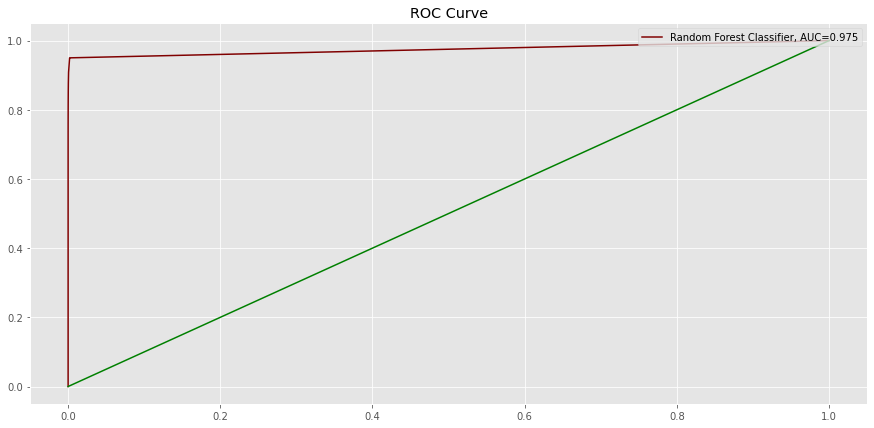

In [37]:
fpr, tpr, temp = roc_curve(y_test, rfc_pred_proba)
auc = round(roc_auc_score(y_test, rfc_pred_proba),3)
plt.figure(figsize=(15,7))
plt.plot(fpr,tpr,label='Random Forest Classifier, AUC='+str(auc),linestyle='solid',color='#800000')
plt.plot([0, 1], [0, 1], color = 'g')
plt.title('ROC Curve')
plt.legend(loc='upper right')